## 1. Introduction

In [1]:
# Libraries
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (cross_val_score, cross_validate, # Cross-validation not used yet !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [18]:
# Load data
fault = pd.read_csv('data/fault_data.csv', parse_dates=['DateTime'])
scada = pd.read_csv('data/scada_data.csv', parse_dates=['DateTime'])
status = pd.read_csv('data/status_data.csv', parse_dates=['Time'])

In [11]:
# Have a look at the fault dataset
fault.head(5)

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF


In [10]:
# Have a look at the scada dataset
scada.head(5)

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [12]:
# Have a look at the status dataset
status.head(5)

,Time,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


### 2. Data Cleaning

#### 2.1 Missing Values

In [5]:
# Check for na values
print('The number of entries containing missing values in the fault dataframe is: ', fault[fault.isnull().any(axis = 1)].shape[0])
print('The number of entries containing missing values in the scada dataframe is: ', scada[scada.isnull().any(axis = 1)].shape[0])
print('The number of entries containing missing values in the status dataframe is: ', status[status.isnull().any(axis = 1)].shape[0])

The number of entries containing missing values in the fault dataframe is:  0
The number of entries containing missing values in the scada dataframe is:  0
The number of entries containing missing values in the status dataframe is:  0


#### 2.2 Duplicates

In [7]:
# Check for duplicate data
print('The number of duplicate rows in the fault dataframe is: ', sum(fault.duplicated()))
print('The number of duplicate rows in the scada dataframe is: ', sum(scada.duplicated()))
print('The number of duplicate rows in the status dataframe is: ', sum(status.duplicated()))

The number of duplicate rows in the fault dataframe is:  0
The number of duplicate rows in the scada dataframe is:  0
The number of duplicate rows in the status dataframe is:  0


#### 2.3 Data types

In [26]:
# Check the data types of fault dataset
fault.dtypes

DateTime    datetime64[ns]
Time               float64
Fault               object
dtype: object

In [13]:
# Check the data types of scada dataset
scada.dtypes

DateTime                 datetime64[ns]
Time                              int64
Error                             int64
WEC: ava. windspeed             float64
WEC: max. windspeed             float64
                              ...      
Control cabinet temp.             int64
Transformer temp.                 int64
RTU: ava. Setpoint 1              int64
Inverter averages               float64
Inverter std dev                float64
Length: 66, dtype: object

In [11]:
# Check the data types of status dataset
status.dtypes

Time           datetime64[ns]
Main Status             int64
Sub Status              int64
Full Status            object
Status Text            object
T                       int64
Service                  bool
FaultMsg                 bool
Value0                float64
dtype: object

In [3]:
# Changing the type of 'Time' column from float to int, to be of same format as 'Time' in the 'scada' dataset - Unix Timestamp
fault.Time = fault.Time.astype(int)

In [19]:
# Rename column 'Time' to 'DateTime' in status dataframe to match the other two dataframes
status.rename({'Time' : 'DateTime'}, axis = 1, inplace = True)

In [20]:
# Rename columns 'Sub status', 'Main status', 'Full Status', 'Status Text' in status dataframe
status.rename({'Main Status' : 'MainStatus'}, axis = 1, inplace = True)
status.rename({'Sub Status' : 'SubStatus'}, axis = 1, inplace = True)
status.rename({'Full Status' : 'FullStatus'}, axis = 1, inplace = True)
status.rename({'Status Text' : 'StatusText'}, axis = 1, inplace = True)

### 3. Exploratory Data Analysis

#### 3.1. Nominal attributes

In [23]:
fault_types = fault.groupby('Fault')

fault_types = fault_types.agg({'count'})['Time']

fault_types

,count
Fault,
AF,62
EF,174
FF,254
GF,43
MF,20


In [24]:
status_meaning = status.groupby(['StatusText', 'FullStatus'])

status_meaning = status_meaning.agg({'count'})['DateTime']

status_meaning

,,count
StatusText,FullStatus,
Air gap monitoring : Sensor 1 blade C,72 : 301,1
Cable twisted : Left (2-3 turns),21 : 1,1
Cable twisted : Right (2-3 turns),21 : 2,11
Calibration of load control,0 : 5,68
Data bus error (Timeout) : Fan inverter,304 : 56,1
Data bus error all inverters,204 : 0,5
Data bus error blade control (timeout) : Blade load control B,307 : 14,1
Excitation error : Overvoltage DC-link,80 : 21,84
Feeding control bus error (Bus-Off) : I/O-board control cabinet,301 : 81,3


In [23]:
# Fix Sub Status from 2 to 1 where Status Text = 'Lack of wind : Wind speed to low' 
status.loc[status.SubStatus == 2, 'SubStatus'] = 1
status.loc[status.FullStatus == '2 : 2', 'FullStatus'] = '2 : 1' # Change the value for FullStatus as well

# Fix Main Status from 66 to 62 (66 is the only value) and change 32 into 919 for Sub Status
status.loc[status.MainStatus == 66, 'MainStatus'] = 62
status.loc[status.SubStatus == 32, 'SubStatus'] = 919
status.loc[status.FullStatus == '66 : 32', 'FullStatus'] = '62 : 919' # Change the value for FullStatus as well

#### 3.2. Time Series analysis
There are three different datasets on different time scales. Therefore it is worth seeing the timespan of the three datasets.

(0.0, 4.0)

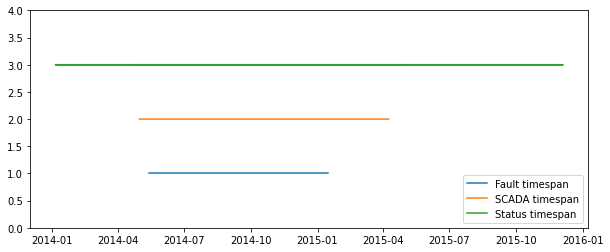

In [26]:
# Ploting the timespans
plt.figure(figsize = (10, 4))
plt.plot(fault.DateTime, np.full(len(fault), 1), label = 'Fault timespan')
plt.plot(scada.DateTime, np.full(len(scada), 2), label = 'SCADA timespan')
plt.plot(status.DateTime, np.full(len(status), 3), label = 'Status timespan')
plt.legend(loc = 'lower right')
plt.ylim(0, 4)

In [ ]:
# Values over time - some plots

#### 3.3 Numerical attributes

### 4. Data Preparation

#### 4.1. Combining datasets

In [25]:
## Check if by adding status to scada will create many missing data
scada_extended = scada.merge(status, on = 'DateTime', how = 'inner' )
scada_extended

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Inverter averages,Inverter std dev,MainStatus,SubStatus,FullStatus,StatusText,T,Service,FaultMsg,Value0
0,2014-09-06,1409979648,0,2.700000,3.500000,2.2,5.71,6.11,5.43,29,...,31.272728,2.686667,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,9.4
1,2014-10-06,1412571648,0,17.799999,24.900000,8.8,14.16,15.09,12.75,3065,...,34.454544,1.863526,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.4
2,2014-11-06,1415253632,0,11.300000,15.700000,8.1,13.84,14.67,12.09,2816,...,28.363636,2.013590,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.5
3,2014-12-06,1417845632,0,7.400000,8.400000,6.2,10.16,10.85,9.66,903,...,21.363636,1.433368,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,3.7
4,2015-01-15,1421301632,0,13.000000,17.200001,9.4,14.69,15.04,14.18,2426,...,24.909090,1.814086,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,17.9
5,2015-01-16,1421388032,0,5.700000,7.200000,4.1,8.42,9.12,7.59,452,...,22.181818,3.188046,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,8.3


In [8]:
data = scada.merge(fault, on = 'Time', how = 'outer')
data[-data.isna().any(axis = 1)]

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.7,7.400000,4.1,9.98,10.23,9.72,0,...,17,26,35,34,2501,25.818182,0.603023,919,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.4,8.600000,2.7,4.12,10.71,0.70,0,...,17,26,35,34,2501,26.090910,0.943880,919,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.6,7.500000,4.0,9.99,10.20,9.80,0,...,17,26,35,34,2501,26.454546,0.820200,919,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.3,6.600000,4.1,9.98,10.17,9.79,0,...,18,26,35,34,2501,26.181818,0.873863,919,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.1,7.200000,3.8,9.99,10.17,9.80,0,...,18,26,35,34,2501,26.181818,0.981650,919,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,8,29,35,57,3050,25.909090,1.814086,919,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,7,22,35,57,3050,28.181818,1.834022,919,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,5,21,28,42,3050,20.909090,1.300350,919,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,5,21,28,42,3050,20.909090,1.300350,919,2015-01-15 23:00:48,AF


The 553 entires have the entries classified as faulty.

In [9]:
# Change the missing values in 'Fault' attribute for the non-faulty entries from "NaN" as "NF" - Not Faulty
data['Fault'] = data['Fault'].replace(np.nan, 'NF')
data

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,12,14,24,34,2501,25.272728,1.103713,919,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,12,14,24,34,2501,25.272728,1.103713,919,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,12,14,24,34,2501,25.272728,1.103713,919,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,12,14,24,34,2501,25.272728,1.103713,919,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,12,14,23,34,2501,25.272728,1.103713,919,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,9,17,27,35,3050,24.454546,3.474583,919,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,9,17,27,35,3050,24.454546,3.445683,919,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,9,18,27,34,3050,24.363636,3.413876,919,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,9,17,27,34,3050,24.000000,3.376389,919,NaT,NF


Heavily unbalanced dataset with class 'NF' rougly 10 times more than the fault classes combined.


In [10]:
# Lower number of instances with class 'NF'
data_nf = data[data.Fault == 'NF'].sample(5000, random_state = 123)
data_allF = data[data.Fault != 'NF']
data = pd.concat((data_nf, data_allF), axis = 0).reset_index(drop = True)
data

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False,DateTime_y,Fault
0,2014-12-20 19:50:00,1419126656,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,...,10,20,27,36,3050,21.909090,1.300350,919,NaT,NF
1,2014-08-05 14:39:00,1407267584,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,...,19,26,35,42,3050,31.272728,2.686667,919,NaT,NF
2,2015-01-28 02:19:00,1422433152,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,...,12,28,36,58,3050,28.818182,2.272364,919,NaT,NF
3,2015-01-27 13:29:00,1422386944,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,...,11,20,27,35,3050,22.000000,1.341641,919,NaT,NF
4,2014-10-22 13:20:00,1414002048,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,...,16,28,36,54,3050,30.909090,2.385563,919,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,2015-01-14 23:00:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,8,29,35,57,3050,25.909090,1.814086,919,2015-01-14 23:00:48,AF
5549,2015-01-14 23:09:00,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,7,22,35,57,3050,28.181818,1.834022,919,2015-01-14 23:09:20,AF
5550,2015-01-15 22:50:00,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,5,21,28,42,3050,20.909090,1.300350,919,2015-01-15 22:50:08,AF
5551,2015-01-15 23:00:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,5,21,28,42,3050,20.909090,1.300350,919,2015-01-15 23:00:48,AF


In [11]:
# Delete useless attributes
data = data.drop(columns = ['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                                            'WEC: ava. available P from wind',
                                                            'WEC: ava. available P technical reasons',
                                                            'WEC: ava. Available P force majeure reasons',
                                                            'WEC: ava. Available P force external reasons',
                                                            'WEC: max. windspeed', 'WEC: min. windspeed', 
                                                            'WEC: Operating Hours', 'WEC: Production kWh',
                                                            'WEC: Production minutes', 'DateTime_y'])
data

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False,Fault
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,26,10,20,27,36,3050,21.909090,1.300350,919,NF
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,35,19,26,35,42,3050,31.272728,2.686667,919,NF
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,27,12,28,36,58,3050,28.818182,2.272364,919,NF
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,25,11,20,27,35,3050,22.000000,1.341641,919,NF
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,30,16,28,36,54,3050,30.909090,2.385563,919,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,14.69,15.19,13.83,2736,2798,2417,-78,238,243,224,...,24,8,29,35,57,3050,25.909090,1.814086,919,AF
5549,2.53,14.67,0.00,20,2746,0,-76,4,241,0,...,23,7,22,35,57,3050,28.181818,1.834022,919,AF
5550,12.79,13.30,11.64,1667,1914,1259,-66,145,170,119,...,21,5,21,28,42,3050,20.909090,1.300350,919,AF
5551,11.71,13.27,9.99,1311,1945,781,-53,111,155,77,...,20,5,21,28,42,3050,20.909090,1.300350,919,AF


In [12]:
# Create dataset for binary classification problem
data_bi = data.replace(['AF', 'EF', 'FF', 'GF', 'MF'], 'F') # All fault are now under the class 'F' - faulty
data_bi.head()

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False,Fault
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,26,10,20,27,36,3050,21.909090,1.300350,919,NF
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,35,19,26,35,42,3050,31.272728,2.686667,919,NF
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,27,12,28,36,58,3050,28.818182,2.272364,919,NF
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,25,11,20,27,35,3050,22.000000,1.341641,919,NF
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,30,16,28,36,54,3050,30.909090,2.385563,919,NF


#### 4.2 Class balancing - oversampling 

In [13]:
# Split class from dataset
# Binary dataset
target_bi = data_bi.Fault
data_bi.drop('Fault', inplace = True, axis = 1)

# Multiclass dataset
target = data.Fault
data.drop('Fault', inplace = True, axis = 1)
data

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,False
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,21,26,10,20,27,36,3050,21.909090,1.300350,919
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,30,35,19,26,35,42,3050,31.272728,2.686667,919
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,25,27,12,28,36,58,3050,28.818182,2.272364,919
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,22,25,11,20,27,35,3050,22.000000,1.341641,919
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,27,30,16,28,36,54,3050,30.909090,2.385563,919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,14.69,15.19,13.83,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909090,1.814086,919
5549,2.53,14.67,0.00,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.181818,1.834022,919
5550,12.79,13.30,11.64,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909090,1.300350,919
5551,11.71,13.27,9.99,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909090,1.300350,919


In [14]:
# SMOTE
sm = SMOTE(random_state = 123)

# Binary classification dataset
data_bi_smote, target_bi_smote = sm.fit_resample(data_bi, target_bi)

# Whole dataset
data_smote, target_smote = sm.fit_resample(data, target)


c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


#### 4.3 Train and Test sets

In [15]:
# Splitting 'data_bi' dataset into training and testing sets
random.seed(123)
X_bi_train, X_bi_test, y_bi_train, y_bi_test = train_test_split(data_bi, target_bi, stratify = target_bi, test_size = 0.2)

print('Class destribution in train set: ', y_bi_train.value_counts(sort = True))
print('Class distribution in test set: ', y_bi_test.value_counts(sort = True))

Class destribution in train set:  NF    4000
F      442
Name: Fault, dtype: int64
Class distribution in test set:  NF    1000
F      111
Name: Fault, dtype: int64


In [16]:
# Splitting 'data' dataset into training and testing sets
random.seed(123)
X_bi_smote_train, X_bi_smote_test, y_bi_smote_train, y_bi_smote_test = train_test_split(data_bi_smote, target_bi_smote, stratify = target_bi_smote, test_size = 0.2)

print('Class destribution in train set: ', y_bi_smote_train.value_counts(sort = True))
print('Class distribution in test set: ', y_bi_smote_test.value_counts(sort = True))

Class destribution in train set:  NF    4000
F     4000
Name: Fault, dtype: int64
Class distribution in test set:  NF    1000
F     1000
Name: Fault, dtype: int64


In [17]:
# Splitting 'data' dataset into training and testing sets
random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify = target, test_size = 0.2)

print('Class destribution in train set: ', y_train.value_counts(sort = True))
print('Class distribution in test set: ', y_test.value_counts(sort = True))

Class destribution in train set:  NF    4000
FF     203
EF     139
AF      50
GF      34
MF      16
Name: Fault, dtype: int64
Class distribution in test set:  NF    1000
FF      51
EF      35
AF      12
GF       9
MF       4
Name: Fault, dtype: int64


In [18]:
# Splitting 'data_smote' dataset into training and testing sets
random.seed(123)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(data_smote, target_smote, stratify = target_smote, test_size = 0.2)

print('Class destribution in train set: ', y_smote_train.value_counts(sort = True))
print('Class distribution in test set: ', y_smote_test.value_counts(sort = True))

Class destribution in train set:  FF    4000
AF    4000
NF    4000
MF    4000
EF    4000
GF    4000
Name: Fault, dtype: int64
Class distribution in test set:  FF    1000
EF    1000
NF    1000
AF    1000
MF    1000
GF    1000
Name: Fault, dtype: int64


#### 4.4 Standardizing

In [19]:
# Defining standardization
sc = StandardScaler()

In [20]:
# Standardizing 'data_bi'
X_bi_train = sc.fit_transform(X_bi_train)
X_bi_test = sc.transform(X_bi_test)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [21]:
# Standardizing 'data_bi_smote'
X_bi_smote_train = sc.fit_transform(X_bi_smote_train)
X_bi_smote_test = sc.transform(X_bi_smote_test)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [22]:
# Standardizing 'data'
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [23]:
# Standardizing 'data_smote' 
X_smote_train = sc.fit_transform(X_smote_train)
X_smote_test = sc.transform(X_smote_test)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


### 5. Machine Learning
#### 5.1 Performance metrics

In [24]:
# Defining performance metrics
scores = ['f1_micro', 'accuracy', 'precision_micro', 'recall_micro']

#### 5.2 Define models

In [25]:
# Support Vector Machine
model_svm = SVC(kernel = 'linear')

In [26]:
# Random Forest 
model_rf = RandomForestClassifier(n_estimators = 30, random_state = 300)

In [35]:
# Artificial Neural Network
model_ann = Sequential()
model_ann.add(Dense(32, input_dim = 54, activation = 'relu'))
model_ann.add(Dense(32, activation = 'relu'))
model_ann.add(Dense(1, activation = 'sigmoid'))

model_ann.summary()

model_ann.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_ann.fit(X_bi_train, y_bi_train, epochs = 5)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                1760      
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'categorical_crossentropy/Cast' defined at (most recent call last):
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\crist\AppData\Local\Temp/ipykernel_13208/2712593240.py", line 11, in <module>
      model_ann.fit(X_bi_train, y_bi_train, epochs = 5)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1779, in categorical_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'categorical_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node categorical_crossentropy/Cast}}]] [Op:__inference_train_function_1397]

#### 5.3 Models fitting

In [46]:
# Binary classification dataset
# Support Vector Machine
random.seed(123)
svm_bi = model_svm.fit(X_bi_train, y_bi_train)
svm_predict_bi = model_svm.predict(X_bi_test)

# Random Forest
random.seed(123)
rf_bi = model_rf.fit(X_bi_train, y_bi_train)
rf_predict_bi = model_rf.predict(X_bi_test)

In [47]:
# SMOTE binary classification dataset
# Support Vector Machine
random.seed(123)
svm_bi_smote = model_svm.fit(X_bi_smote_train, y_bi_smote_train)
svm_predict_bi_smote = model_svm.predict(X_bi_smote_test)

# Random Forest
random.seed(123)
rf_bi_smote = model_rf.fit(X_bi_smote_train, y_bi_smote_train)
rf_predict_bi_smote = model_rf.predict(X_bi_smote_test)

In [48]:
# Multiclass dataset
# Support Vector Machine
random.seed(123)
svm_data = model_svm.fit(X_train, y_train)
svm_predict = model_svm.predict(X_test)

# Random Forest
random.seed(123)
rf_data = model_rf.fit(X_train, y_train)
rf_predict = model_rf.predict(X_test)

In [49]:
# SMOTE multiclass dataset
# Support Vector Machine
random.seed(123)
svm_smote = model_svm.fit(X_smote_train, y_smote_train)
svm_predict_smote = model_svm.predict(X_smote_test)

# Random Forest
random.seed(123)
rf_smote = model_rf.fit(X_smote_train, y_smote_train)
rf_predict_smote = model_rf.predict(X_smote_test)

### 6. Evaluations
#### 6.1 Accuracy

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

# Support Vector Machine
print('Accuracy of Binomial classification dataset on SVM: ', accuracy_score(svm_predict_bi, y_bi_test))
print('Accuracy of SMOTE Binomial classification dataset on SVM: ', accuracy_score(svm_predict_bi_smote, y_bi_smote_test))
print('Accuracy of Multiclassification dataset on SVM: ', accuracy_score(svm_predict, y_test))
print('Accuracy of SMOTE Multiclassification dataset on SVM: ', accuracy_score(svm_predict_smote, y_smote_test))
print(' ')

# Random Forest
print('Accuracy of Binomial classification dataset on RF: ', accuracy_score(rf_predict_bi, y_bi_test))
print('Accuracy of SMOTE Binomial classification dataset on RF: ', accuracy_score(rf_predict_bi_smote, y_bi_smote_test))
print('Accuracy of Multiclassification dataset on RF: ', accuracy_score(rf_predict, y_test))
print('Accuracy of SMOTE Multiclassification dataset on RF: ', accuracy_score(rf_predict_smote, y_smote_test))

Accuracy of Binomial classification dataset on SVM:  0.9351935193519352
Accuracy of SMOTE Binomial classification dataset on SVM:  0.936
Accuracy of Multiclassification dataset on SVM:  0.945994599459946
Accuracy of SMOTE Multiclassification dataset on SVM:  0.892
 
Accuracy of Binomial classification dataset on RF:  0.9675967596759676
Accuracy of SMOTE Binomial classification dataset on RF:  0.9825
Accuracy of Multiclassification dataset on RF:  0.9360936093609361
Accuracy of SMOTE Multiclassification dataset on RF:  0.9283333333333333


#### 6.2 Precision

In [56]:
# Support Vector Machine
print('Precision of Binomial classification dataset on SVM: ', precision_score(svm_predict_bi, y_bi_test,average = 'micro'))
print('Precision of SMOTE Binomial classification dataset on SVM: ', precision_score(svm_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('Precision of Multiclassification dataset on SVM: ', precision_score(svm_predict, y_test, average = 'micro'))
print('Precision of SMOTE Multiclassification dataset on SVM: ', precision_score(svm_predict_smote, y_smote_test, average = 'micro'))
print(' ')

# Random Forest
print('Precision of Binomial classification dataset on RF: ', precision_score(rf_predict_bi, y_bi_test, average = 'micro'))
print('Precision of SMOTE Binomial classification dataset on RF: ', precision_score(rf_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('Precision of Multiclassification dataset on RF: ', precision_score(rf_predict, y_test, average = 'micro'))
print('Precision of SMOTE Multiclassification dataset on RF: ', precision_score(rf_predict_smote, y_smote_test, average = 'micro'))

Precision of Binomial classification dataset on SVM:  0.9351935193519352
Precision of SMOTE Binomial classification dataset on SVM:  0.936
Precision of Multiclassification dataset on SVM:  0.945994599459946
Precision of SMOTE Multiclassification dataset on SVM:  0.892
 
Precision of Binomial classification dataset on RF:  0.9675967596759676
Precision of SMOTE Binomial classification dataset on RF:  0.9825
Precision of Multiclassification dataset on RF:  0.9360936093609361
Precision of SMOTE Multiclassification dataset on RF:  0.9283333333333333


#### 6.3 Recall

In [55]:
# Support Vector Machine
print('Recall of Binomial classification dataset on SVM: ', recall_score(svm_predict_bi, y_bi_test,average = 'micro'))
print('Recall of SMOTE Binomial classification dataset on SVM: ', recall_score(svm_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('Recall of Multiclassification dataset on SVM: ', recall_score(svm_predict, y_test, average = 'micro'))
print('Recall of SMOTE Multiclassification dataset on SVM: ', recall_score(svm_predict_smote, y_smote_test, average = 'micro'))
print(' ')

# Random Forest
print('Recall of Binomial classification dataset on RF: ', recall_score(rf_predict_bi, y_bi_test, average = 'micro'))
print('Recall of SMOTE Binomial classification dataset on RF: ', recall_score(rf_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('Recall of Multiclassification dataset on RF: ', recall_score(rf_predict, y_test, average = 'micro'))
print('Recall of SMOTE Multiclassification dataset on RF: ', recall_score(rf_predict_smote, y_smote_test, average = 'micro'))

Recall of Binomial classification dataset on SVM:  0.9351935193519352
Recall of SMOTE Binomial classification dataset on SVM:  0.936
Recall of Multiclassification dataset on SVM:  0.945994599459946
Recall of SMOTE Multiclassification dataset on SVM:  0.892
 
Recall of Binomial classification dataset on RF:  0.9675967596759676
Recall of SMOTE Binomial classification dataset on RF:  0.9825
Recall of Multiclassification dataset on RF:  0.9360936093609361
Recall of SMOTE Multiclassification dataset on RF:  0.9283333333333333


#### 6.4 F-1 Score

In [54]:
# Support Vector Machine
print('F-1 Score of Binomial classification dataset on SVM: ', f1_score(svm_predict_bi, y_bi_test,average = 'micro'))
print('F-1 Score of SMOTE Binomial classification dataset on SVM: ', f1_score(svm_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('F-1 Score of Multiclassification dataset on SVM: ', f1_score(svm_predict, y_test, average = 'micro'))
print('F-1 Score of SMOTE Multiclassification dataset on SVM: ', f1_score(svm_predict_smote, y_smote_test, average = 'micro'))
print(' ')

# Random Forest
print('F-1 Score of Binomial classification dataset on RF: ', f1_score(rf_predict_bi, y_bi_test, average = 'micro'))
print('F-1 Score of SMOTE Binomial classification dataset on RF: ', f1_score(rf_predict_bi_smote, y_bi_smote_test, average = 'micro'))
print('F-1 Score of Multiclassification dataset on RF: ', f1_score(rf_predict, y_test, average = 'micro'))
print('F-1 Score of SMOTE Multiclassification dataset on RF: ', f1_score(rf_predict_smote, y_smote_test, average = 'micro'))

F-1 Score of Binomial classification dataset on SVM:  0.9351935193519352
F-1 Score of SMOTE Binomial classification dataset on SVM:  0.936
F-1 Score of Multiclassification dataset on SVM:  0.945994599459946
F-1 Score of SMOTE Multiclassification dataset on SVM:  0.892
 
F-1 Score of Binomial classification dataset on RF:  0.9675967596759676
F-1 Score of SMOTE Binomial classification dataset on RF:  0.9825
F-1 Score of Multiclassification dataset on RF:  0.9360936093609361
F-1 Score of SMOTE Multiclassification dataset on RF:  0.9283333333333333
